# Pre-Class 7.2

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random as rd

In [5]:
class AdaptiveDiffusionSimulation:
    '''
    An implementation of the adaptive diffusion model.
    '''

    def __init__(self, n_nodes=20, node_degree=3):
        '''
        Inputs:

            initial_nodes (int) The number of nodes from which
              the small-world graph starts growing. A complete
              graph with this many nodes will be created when
              the initialize() method below is called.
              Default: 5.

            new_node_degree (int) Every new node that is added
              to the graph will be connected to this many nodes
              in the existing graph.
        '''
        if n_nodes < node_degree:
            raise ValueError(
                'Need at least as many initial nodes (%r) as the new node degree (%r)' %
                (n_nodes, node_degree))
        self.n_nodes = n_nodes
        self.node_degree = node_degree
        self.alpha = 0.03 # diffusion constant
        self.beta = 0.3 # rate of adaptive edge weight change
        self.gamma = 4 # pickiness of nodes
        self.steps = 0

    def initialize(self):
        '''
        Create a new graph for the simulation, starting with a small-world graph using 
        the Barabasi-Albert algorithm.
        '''
        self.graph = nx.barabasi_albert_graph(self.n_nodes, self.node_degree)
        for i, j in self.graph.edges:
            self.graph.edges[i,j]['weight'] = 0.5
        for i in self.graph.nodes:
            self.graph.nodes[i]['state'] = 1 if np.random.uniform(0, 1) > 0.5 else 0
        self.layout = nx.spring_layout(self.graph)
        
    def observe(self):
        '''
        Update the matplotlib figure for the simulation visualization.
        '''
        plt.clf()
        # Plot network layout, color coding nodes by their degree
#         plt.subplot(1, 3, 1)
        degree = np.array([self.graph.degree[i] for i in self.graph.nodes])
        states = np.array([self.graph.nodes[i]['state'] for i in self.graph.nodes])
        nx.draw(
            self.graph, pos=self.layout,
            node_color=-states, alpha=0.8)
        plt.title('Nodes: ' + str(len(degree)))
#         # Histogram of shortest path lengths between all pairs of nodes
#         plt.subplot(1, 3, 2)
#         lengths = []
#         for source, source_lengths in nx.all_pairs_shortest_path_length(self.graph):
#             lengths.extend(x[1] for x in source_lengths.items() if x[0] > source)
#         plt.hist(lengths, bins=10, range=(0.5, 10.5), rwidth=0.8)
#         plt.title('Shortest path distribution')
#         # Histogram of degrees of all nodes
#         plt.subplot(1, 3, 3)
#         plt.hist(degree, bins=10, range=(0.5, 10.5), rwidth=0.8)
#         plt.title('Degree distribution')

    def update(self):
        '''
        Add one new node to the existing graph and connect it to existing
        nodes using preferential attachment.
        '''
        self.steps += 1
        # Select a random edge in the network
        rand_edge = rd.choice(list(self.graph.edges))
        
        # Part 1: change people's opioions
        ## Calculate by how much to change the opinion
        delta_opinion = self.alpha * self.graph.edges[rand_edge]['weight'] * \
                        abs(self.graph.nodes[rand_edge[0]]['state'] - 
                            self.graph.nodes[rand_edge[1]]['state'])
        ## Change the opinions by delta_opinion to bring them closer
        if self.graph.nodes[rand_edge[0]]['state'] > self.graph.nodes[rand_edge[1]]['state']:
            self.graph.nodes[rand_edge[0]]['state'] -= delta_opinion
            self.graph.nodes[rand_edge[1]]['state'] += delta_opinion
        else:
            self.graph.nodes[rand_edge[0]]['state'] += delta_opinion
            self.graph.nodes[rand_edge[1]]['state'] -= delta_opinion
            
        # Part 2: change their relationships
        ## Calculate by how much to change
        delta_weight = self.beta * self.graph.edges[rand_edge]['weight'] * \
                        (1 - self.graph.edges[rand_edge]['weight']) * \
                        (1 - self.gamma * abs(self.graph.nodes[rand_edge[0]]['state'] - 
                                              self.graph.nodes[rand_edge[1]]['state']))
        ## Change the weight of the relationship
        self.graph.edges[rand_edge]['weight'] += delta_weight
        
        # Part 3: add random social connections every 100 steps
        if self.steps % 100 == 0:
            optional_nodes = list(self.graph.nodes)
            i = rd.choice(optional_nodes)
            optional_nodes.remove(i)
            if self.graph.degree[i] > 0:
                for j in self.graph.neighbors(i):
                    optional_nodes.remove(j)
                j = rd.choice(optional_nodes)
                self.graph.add_edge(i, j)
                self.graph.edges[i,j]['weight'] = 0.5


/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


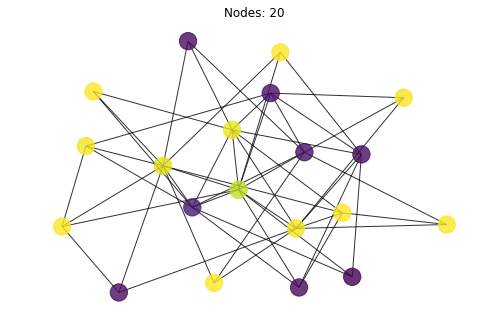

In [7]:
sim = AdaptiveDiffusionSimulation(n_nodes=20, node_degree=3)
sim.initialize()
sim.observe()

for i in range(150):
    sim.update()
sim.observe()

In [6]:
sim = BarabasiAlbertSimulation(new_node_degree=3)
sim.initialize()

def animate_simulation(frame, total_frames):
    sim.update()
    sim.observe()

make_animation(
    animate_simulation, frames=100, interval=250,
    figure_params={'figsize': (14, 4)},
    verbose=True)

### Additional task (optional)

You can create a ready-made Barabási–Albert graph using the `networkx` function `barabasi_albert_graph(n, m)` where `n` is the total number of nodes and `m` is the number of edges by which each newcomer node is connected to the graph.

Generate graphs of different sizes and check that the degree distribution of the graph follows a power law distribution.

## Visualizations

In [ ]:
#
# NOTE: This cell contains the function for making animations in CoCalc.
#       You do not have to work through this code. Start at the next cell.
#

def make_animation(draw_function, frames, interval, filename=None,
                   verbose=False, figure_params=None):
    """
    Write an animated GIF to file using matplotlib and ImageMagick.

    Inputs:

        draw_function (callable) The function to call, once per frame,
          to render to the current matplotlib figure. This function's call
          signature must be

            draw_function(current_frame_number, total_frame_count)

          The first frame is 0 and the last frame is total_frame_count-1.

        frames (int) The number of frames to generate.

        interval (float) The number of milliseconds to wait between frames
          in the animation. Set this to 40 for a fairly standard frame rate
          of 25fps (1 second / 40 (milliseconds per frame) = 25 frames per
          second).

        filename (str) The path to the file to write to. If none is provided,
          the animation will be written to a random filename, prefixed with
          "animate_" in the current directory. Default: None.

        verbose (bool) Whether to print the current frame number to the
          console as the animation is being created. This will clear other
          console output. Default: False.

        figure_params (dict) The keyword arguments to pass to matplotlib
          when creating a new figure for this animation. Use it to set the
          figure size and other figure properties. Default: None.

    Returns: A display object that will inject HTML for displaying the
      animated GIF into the notebook.
    """
    from matplotlib import pyplot, animation
    from IPython.display import HTML, display, clear_output
    import random

    if filename is None:
        filename = 'animate_%06i.gif' % random.randint(0, 999999)
    # Create figure
    if figure_params is None:
        figure_params = {}
    figure = pyplot.figure(**figure_params)
    # Wrap draw_function if we need to print to console
    if verbose:
        old_draw_function = draw_function
        def draw_function(current_frame_number, total_frame_count):
            old_draw_function(current_frame_number, total_frame_count)
            print('Processed frame', current_frame_number + 1, '/', total_frame_count)
            clear_output(wait=True)
            if current_frame_number + 1 == total_frame_count:
                print('Writing animation to file...')
                clear_output(wait=True)
    # Generate animation
    anim = animation.FuncAnimation(
        figure, draw_function, frames=frames, interval=interval,
        init_func=lambda: None, fargs=(frames,))
    anim.save(filename, writer='imagemagick')
    # Close the animation figure so the last frame does not get displayed
    # in the notebook.
    pyplot.close()
    # Return display object for the animated GIF
    return display(HTML('<img src="' + filename + '">'))